In [892]:
import math
from pprint import pprint
import numpy as np
import pandas as pd
from datetime import datetime
import json
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, fisher_exact, mannwhitneyu, norm
from statsmodels.stats import contingency_tables
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score
import xgboost as xgb
import warnings
from category_encoders import TargetEncoder
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')



def abline(slope, intercept, xrange):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = T
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def shortest_distance(x1, y1, a, b, c):
    """Calculate the shortest (Perpendicular) distance between a point and a plane"""
    d = abs((a * x1 + b * y1)) / (math.sqrt(a * a + b * b))
    return d

def roc(model, features, label, xrange):
    res = pd.DataFrame(model.predict_proba(features)[:,1], columns=['Model Prob']).T

    for t in xrange:
        res.loc[f'p>{t}',:] = res.loc['Model Prob'].apply(lambda p: 1 if p>t else 0)

    tp_rates = [recall_score(res.loc[f'p>{t}',:].values.astype(int), label) for t in xrange]
    fp_rates = [1 - recall_score(res.loc[f'p>{t}',:].apply(lambda x: 1-x).values.astype(int), 1-label) for t in xrange]
    roc_df = pd.DataFrame({'T': xrange, 'TPR': tp_rates, 'FPR': fp_rates}).drop_duplicates(subset=['TPR','FPR'])
    tp_rates = roc_df.TPR.tolist()
    fp_rates = roc_df.FPR.tolist()


    for i in roc_df.index.values:
        roc_df.loc[i, "Distance"] = shortest_distance(x1=roc_df.loc[i,'FPR'], y1=roc_df.loc[i,'TPR'], a=-1, b=1, c=0)

    roc_df = roc_df[roc_df.TPR >= roc_df.FPR]
    roc_df.sort_values(by=['Distance','T'], ascending=[False,True], inplace=True)
    roc_df.reset_index(drop=True, inplace=True)
    
    return roc_df


def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymptotics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

In [893]:
randomized_data = pd.read_excel("NP-003-Taffix Final Randomization List.xlsx")
randomized_data.rename({"Randomization Number": "Patient"}, axis=1, inplace=True)
randomized_data.sort_values(by=["Patient"], ascending=True, inplace=True)
randomized_data = randomized_data.iloc[:217]
randomized_data = randomized_data[["Patient","Treatment"]]

randomized_data.head()

Patient Treatment
0        1   Placebo
1        2    TaffiX
2        3    TaffiX
3        4   Placebo
4        5    TaffiX

In [894]:
symptoms_data = pd.read_excel("symptoms.xlsx")
symptoms_data.rename({"Subject number": "Patient"}, axis=1, inplace=True)
symptoms_data.drop(columns="None", inplace=True)
symptoms_data = symptoms_data[symptoms_data.Patient.apply(lambda x: x.isdigit())]
symptoms_data["Patient"] = symptoms_data.Patient.astype(int)
symptoms_data.sort_values(by=["Patient"], ascending=True, inplace=True)
symptoms_data = symptoms_data.iloc[:216]
symptoms_data.replace('-',np.nan, inplace=True)
symptoms_data.dropna(how='all', axis=1, inplace=True)

symptoms_df = symptoms_data.copy()
symptoms_df.loc[:,symptoms_df.columns.values[1:]] = symptoms_df.loc[:,symptoms_df.columns.values[1:]].notnull().astype('int')
symptoms_df.reset_index(drop=True, inplace=True)

symptoms_data.dropna(subset=symptoms_data.columns.values[1:], how='all', axis=0, inplace=True)
symptoms_data.reset_index(drop=True, inplace=True)
for c in symptoms_data.columns.values[1:]:
    symptoms_data.loc[:,c] = symptoms_data.loc[:,c].apply(lambda x: np.nan if pd.isna(x) else str(datetime.strptime(x.split(',')[0], '%d-%b-%y').date()))

symptoms_data.head()

Patient       Cough Rigors Myalgia    Headache Vomiting or Diarrhea  \
0        4         NaN    NaN     NaN  2021-06-17                  NaN   
1        5         NaN    NaN     NaN         NaN                  NaN   
2       10         NaN    NaN     NaN  2021-07-08                  NaN   
3       11  2021-06-02    NaN     NaN  2021-06-02                  NaN   
4       22         NaN    NaN     NaN         NaN                  NaN   

  Shortness of breath Breathing difficulties  \
0                 NaN                    NaN   
1                 NaN                    NaN   
2                 NaN                    NaN   
3                 NaN             2021-06-02   
4                 NaN                    NaN   

  New olfactory and taste disorder(s) Occurrence of Runny or stuffy nose  \
0                                 NaN                         2021-06-17   
1                          2021-06-08                                NaN   
2                                 NaN                                NaN   
3                                 NaN                                NaN   
4                                 NaN                         2021-07-07   

  Sore throat  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

In [895]:
subject_age = pd.read_excel("subjects.xlsx")
subject_age = subject_age[['Patient','Age']]
subject_age = subject_age[subject_age.Patient.apply(lambda x: x.isdigit())]
subject_age["Patient"] = subject_age.Patient.astype(int)
subject_age.sort_values(by="Patient", ascending=True, inplace=True)
subject_age = subject_age.iloc[:216]
subject_age.head()

Patient  Age
0        1   61
1        2   15
2        3   44
3        4   19
4        5   42

In [896]:
nasus_data = pd.read_excel("Nasus All questionnaires answers.xlsx")
nasus_data = nasus_data[nasus_data.Patient.apply(lambda x: x.isdigit())]
nasus_data["Patient"] = nasus_data.Patient.astype(int)
nasus_data.sort_values(by="Patient", ascending=True, inplace=True)
nasus_data = nasus_data.set_index("Patient").loc[1:217].reset_index(drop=False)
nasus_data = subject_age.merge(nasus_data, on=["Patient"], how="inner")
nasus_data = randomized_data.merge(nasus_data, on=["Patient"], how="inner")
nasus_data = symptoms_df.merge(nasus_data, on=["Patient"], how="inner")
nasus_data.drop(columns=['Page 1: Subject number','Page 1: Informed consent version',
        'Page 1: Consent form and related study documents were thoroughly reviewed with the subject',
        'Page 1: Informed consent Language','Page 1: Date of informed consent signature',
        'Page 1:  Serology test results', 'Page 4: Batch number', 'Page 2:  Year of Birth',
        'Page 2: Was the questionnaire completed?', 'Page 3: Is the patient Eligible?',
        'Page 3: Subjects  who have not previously been infected with COVID-19 to the best of their knowledge',
        'Page 3: Were not vaccinated yet against COVID-19 and will not be vaccinated during the study',
        'Page 3:  Negative serology rapid test to COVID-19',
        'Page 3: Be informed of the nature of the study and the procedures and signed an informed consent',
        'Page 3:  Willing and able to comply with Protocol requirements',
        'Page 3: If female of childbearing potential, agree to use an acceptable method of birth control or be surgically sterile, and have a negative pregnancy test',
        'Page 3:  Test result', 'Page 5: Have you been diagnosed with Covid -19 since last asked?',
        'Page 8:  Was a Rapid serology test performed at EOS?', 'Page 8:  Test result',
        'Page 13:  Were there any device deficiency events during subject’s participation?'], inplace=True)
nasus_data.fillna({c:'No' for c in nasus_data.columns if c.endswith("?")}, inplace=True)
nasus_data.fillna({c:'NA' for c in nasus_data.columns if not c.endswith("?")}, inplace=True)
nasus_data.replace(to_replace="N/A", value="NA", inplace=True)
nasus_data.fillna("NA", inplace=True)
for c in nasus_data.columns[13:]:
    nasus_data[c] = nasus_data[c].apply(lambda x: x.split('_x000D_\n')[-1] if len(x) > 0 else x).astype(str)  
nasus_data.replace(to_replace=['NA','N/A'], value=np.nan, inplace=True)
nasus_data.loc[nasus_data["Page 3: Did the subject perform a pregnancy test?"] == "Yes", "Page 2: Gender"] = "Female"
nasus_data.loc[nasus_data["Page 8: Did the subject perform a pregnancy test?"] == "Yes", "Page 2: Gender"] = "Female"
nasus_data['Page 5: Have you been having any of the following symptoms?'].replace('None','No', inplace=True)
nasus_data['Page 12: Protocol Deviations'].fillna('No', inplace=True)
nasus_data.dropna(axis=0, how="all", inplace=True)
nasus_data.dropna(axis=1, how="all", inplace=True)
nasus_data['Page 2: Occupation'].replace('Menager', 'Manager', inplace=True)
nasus_data['Page 1: Date of visit'] = pd.to_datetime(nasus_data['Page 1: Date of visit'])
nasus_data.fillna({"Page 7: Change in patient's condition": "No",
                   "Page 7:  Does the patient has symptoms or changes in this condition and medication following the use of TaffiX™ or the placebo": "No"}, inplace=True)
nasus_data['Page 5:  How many working days did you lose due to illness since your last report?'] = nasus_data['Page 5:  How many working days did you lose due to illness since your last report?'].replace('No',0).astype(int)
nasus_data['Page 2: No. of people who live at your house (including you)'] = nasus_data['Page 2: No. of people who live at your house (including you)'].astype(int)


nasus_data['Page 8:  Patient COVID-19 Status'].fillna('Negative', inplace=True)
nasus_data["Page 11: Event"].replace(['[{}]','[{},{}]'], np.nan, inplace=True)

nasus_data = nasus_data.merge(symptoms_data.rename({c: 'Days till ' + c for c in symptoms_data.columns.values[1:]}, axis=1), on=['Patient'], how='left')
for c in ['Days till ' + c for c in symptoms_data.columns.values[1:]]:
    nasus_data[c] = (pd.to_datetime(nasus_data[c]) - nasus_data['Page 1: Date of visit']).apply(lambda x: x.days)

nasus_data.head()

Patient  Cough  Rigors  Myalgia  Headache  Vomiting or Diarrhea  \
0        1      0       0        0         0                     0   
1        2      0       0        0         0                     0   
2        3      0       0        0         0                     0   
3        4      0       0        0         1                     0   
4        5      0       0        0         0                     0   

   Shortness of breath  Breathing difficulties  \
0                    0                       0   
1                    0                       0   
2                    0                       0   
3                    0                       0   
4                    0                       0   

   New olfactory and taste disorder(s)  Occurrence of Runny or stuffy nose  \
0                                    0                                   0   
1                                    0                                   0   
2                                    0                                   0   
3                                    0                                   1   
4                                    1                                   0   

   Sore throat Treatment  Age Page 1: Date of visit Page 2: Gender  \
0            0   Placebo   61            2021-05-19         Female   
1            0    TaffiX   15            2021-05-19           Male   
2            0    TaffiX   44            2021-05-19           Male   
3            0   Placebo   19            2021-05-19           Male   
4            0    TaffiX   42            2021-05-20         Female   

  Page 2: Residence (city) Page 2: Job residence(city)  \
0                    Sofia                       Sofia   
1                    Sofia                         NaN   
2                    Sofia                       Sofia   
3                    Sofia                         NaN   
4                    Sofia                       Sofia   

   Page 2: No. of people who live at your house (including you)  \
0                                                  2              
1                                                  3              
2                                                  3              
3                                                  4              
4                                                  3              

  Page 2: Occupation Page 2: Have you been diagnosed with hypertension?  \
0             Doctor                                                 No   
1                NaN                                                 No   
2        Taxi driver                                                 No   
3                NaN                                                 No   
4              Clerk                                                 No   

  Page 2: Have been diagnosed with a cardiovascular disease?  \
0                                                 No           
1                                                 No           
2                                                 No           
3                                                 No           
4                                                 No           

  Page 2: Have you been diagnosed with Diabetes?  \
0                                             No   
1                                             No   
2                                             No   
3                                             No   
4                                             No   

  Page 2: Have you been diagnosed with asthma?  \
0                                           No   
1                                           No   
2                                           No   
3                                           No   
4                                           No   

  Page 2:  Have you been diagnosed with Allergic Rhinitis?  \
0                                                 No         
1                                                 No         
2  

In [897]:
print("1. All subjects are bulgarian.")
print("2. Consent form and related study documents were thoroughly reviewed with all the subjects.")
print("3. All subjects had negative or unknown serology test results.")
print("4. All subjects have completed their questionnaire.")
print("5. All subjects are eligible.")
print("6. All subjects have not previously been infected with COVID-19 to the best of their knowledge.")
print("7. All subjects were not vaccinated yet against COVID-19 and will not be vaccinated during the study.")
print("8. All subjects have shown negative serology rapid test to COVID-19 prior to the study.")
print("9. All subjects were being informed of the nature of the study and the procedures and signed an informed consent.")
print("10. All subjects are willing and able to comply with protocol requirements.")
print("11. All subjects have not been diagnosed with COVID-19 since last asked.")
print("12. All subjects among female subjects of childbearing potential, that agree to use an acceptable method of birth control or be surgically sterile, had a negative pregnancy test.")
print("13. All female subjects who performed a pregnancy test had a negative result.")
print("14. There were no device deficiency events during the subjects participation.")

1. All subjects are bulgarian.
2. Consent form and related study documents were thoroughly reviewed with all the subjects.
3. All subjects had negative or unknown serology test results.
4. All subjects have completed their questionnaire.
5. All subjects are eligible.
6. All subjects have not previously been infected with COVID-19 to the best of their knowledge.
7. All subjects were not vaccinated yet against COVID-19 and will not be vaccinated during the study.
8. All subjects have shown negative serology rapid test to COVID-19 prior to the study.
9. All subjects were being informed of the nature of the study and the procedures and signed an informed consent.
10. All subjects are willing and able to comply with protocol requirements.
11. All subjects have not been diagnosed with COVID-19 since last asked.
12. All subjects among female subjects of childbearing potential, that agree to use an acceptable method of birth control or be surgically sterile, had a negative pregnancy test.
13. 

In [898]:
nasus_data.columns.tolist()

['Patient',
 'Cough',
 'Rigors',
 'Myalgia',
 'Headache',
 'Vomiting or Diarrhea',
 'Shortness of breath',
 'Breathing difficulties',
 'New olfactory and taste disorder(s)',
 'Occurrence of Runny or stuffy nose',
 'Sore throat',
 'Treatment',
 'Age',
 'Page 1: Date of visit',
 'Page 2: Gender',
 'Page 2: Residence (city)',
 'Page 2: Job residence(city)',
 'Page 2: No. of people who live at your house (including you)',
 'Page 2: Occupation',
 'Page 2: Have you been diagnosed with hypertension?',
 'Page 2: Have been diagnosed with a cardiovascular disease?',
 'Page 2: Have you been diagnosed with Diabetes?',
 'Page 2: Have you been diagnosed with asthma?',
 'Page 2:  Have you been diagnosed with Allergic Rhinitis?',
 'Page 3: Known sensitivity to citric acid and /or sodium citrate and /or benzalkonium chloride and /or HPMC and /or lactose',
 'Page 3: Females who are pregnant, or are lactating as reported by the subject',
 'Page 3: Did the subject perform a pregnancy test?',
 'Page 3: Pre

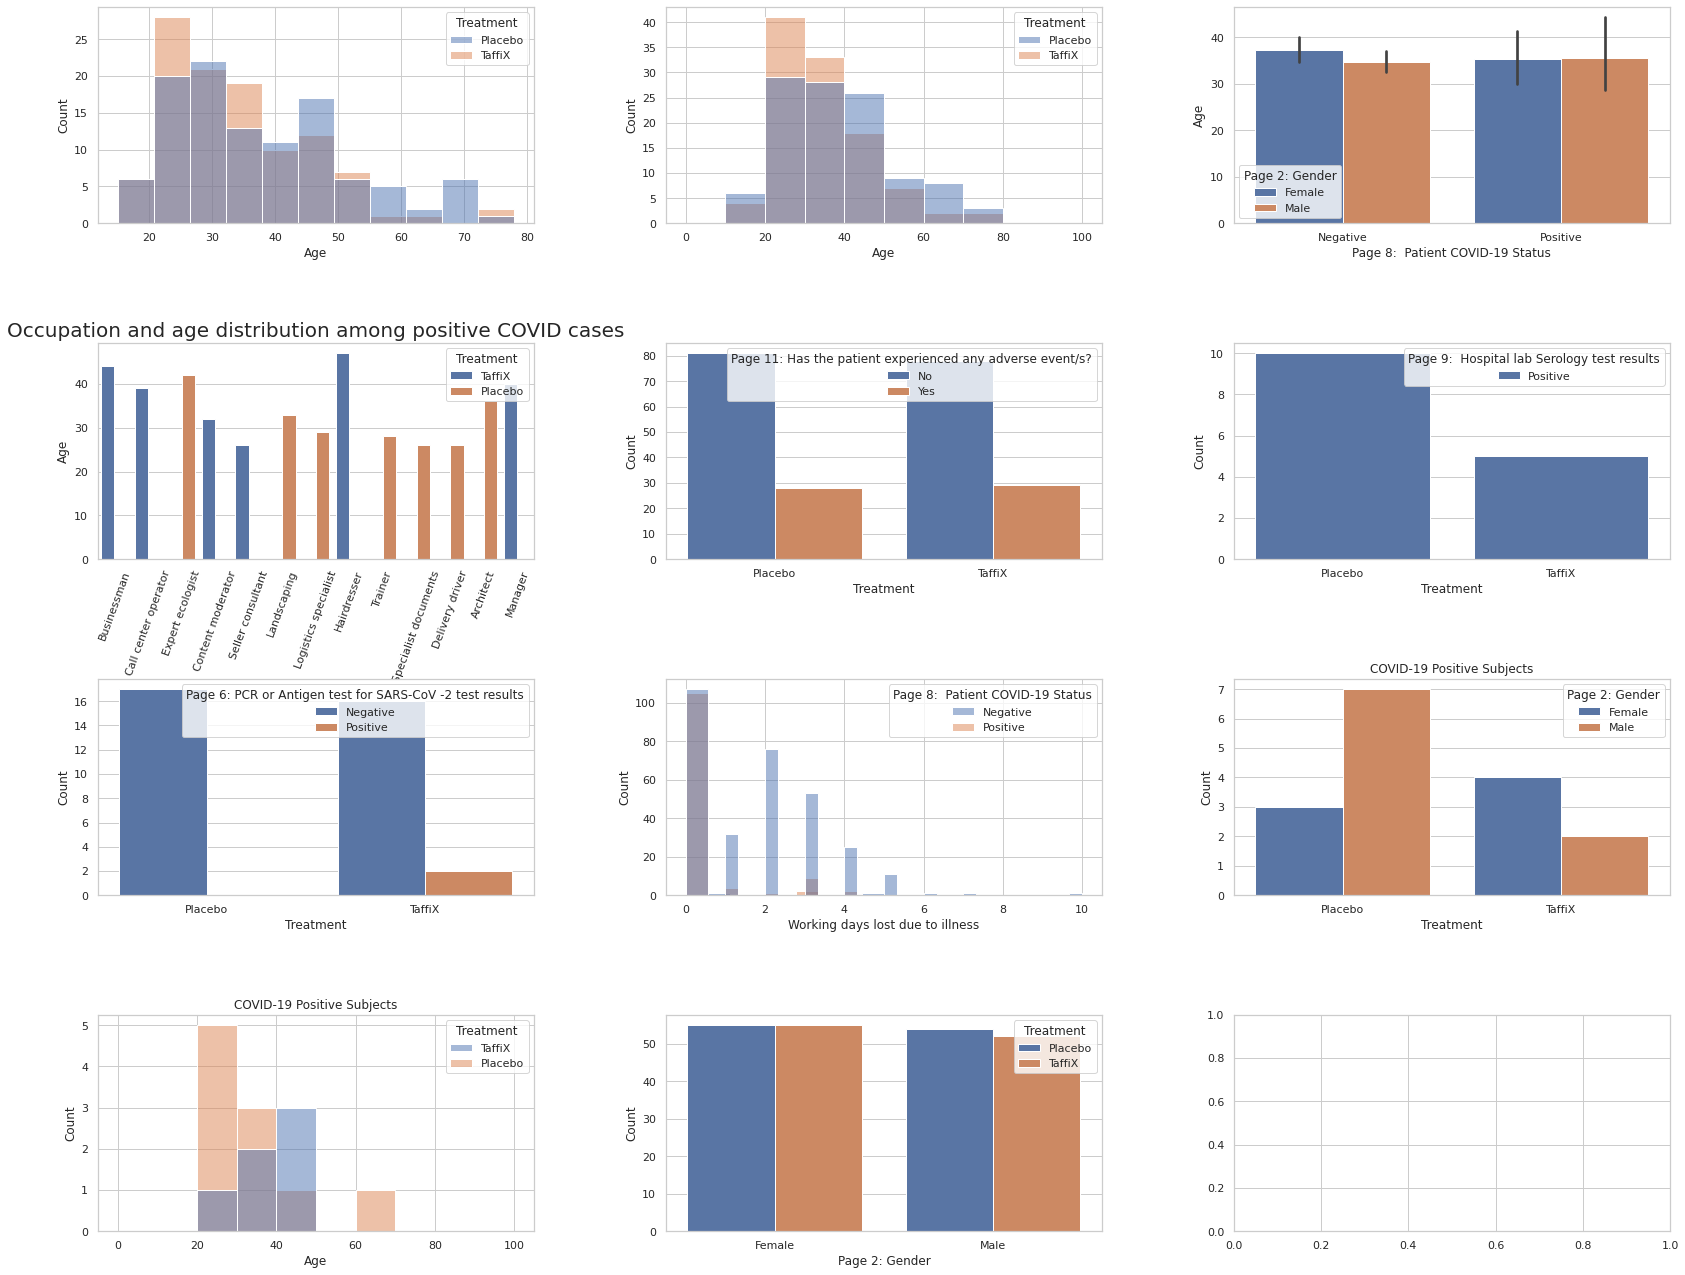

In [557]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25,20))
fig.tight_layout(pad=8.0)

sns.histplot(x='Age', data=nasus_data, hue='Treatment', ax=axes[0,0])
sns.histplot(x='Age', data=nasus_data, hue='Treatment', bins=np.arange(0,110,10), ax=axes[0,1])
sns.barplot(x ='Page 8:  Patient COVID-19 Status', y='Age', hue='Page 2: Gender', data=nasus_data, ax=axes[0,2])
sns.barplot(x='Page 2: Occupation', y='Age', hue='Treatment', data=nasus_data[nasus_data['Page 8:  Patient COVID-19 Status'] == 'Positive'], ax=axes[1,0])
axes[1,0].set_title('Occupation and age distribution among positive COVID cases', fontsize=20)
axes[1,0].set_xticklabels(labels=axes[1,0].get_xticklabels(), rotation=70)
sns.barplot(x='Treatment', y='Count', hue='Page 11: Has the patient experienced any adverse event/s?', data=nasus_data.groupby(['Treatment','Page 11: Has the patient experienced any adverse event/s?']).count().Patient.reset_index().rename({"Patient":"Count"}, axis=1), ax=axes[1,1])
sns.barplot(x='Treatment', y='Count', hue='Page 9:  Hospital lab Serology test results', data=nasus_data.groupby(['Treatment','Page 9:  Hospital lab Serology test results']).count().Patient.reset_index().rename({"Patient":"Count"}, axis=1), ax=axes[1,2])
sns.barplot(x='Treatment', y='Count', hue='Page 6: PCR or Antigen test for SARS-CoV -2 test results', data=nasus_data.groupby(['Treatment','Page 6: PCR or Antigen test for SARS-CoV -2 test results']).count().Patient.reset_index().rename({"Patient":"Count"}, axis=1), ax=axes[2,0])
sns.histplot(x='Working days lost due to illness', hue='Treatment', data=nasus_data.rename({'Page 5:  How many working days did you lose due to illness since your last report?': 'Working days lost due to illness'}, axis=1), ax=axes[2,1])
sns.histplot(x='Page 2: No. of people who live at your house (including you)', hue='Page 8:  Patient COVID-19 Status', data=nasus_data, ax=axes[2,1])
sns.barplot(x='Treatment', y='Count', hue='Page 2: Gender', data=nasus_data[nasus_data['Page 8:  Patient COVID-19 Status'] == 'Positive'].groupby(['Treatment','Page 2: Gender']).count().Patient.reset_index().rename({"Patient":"Count"}, axis=1), ax=axes[2,2])
axes[2,2].set_title('COVID-19 Positive Subjects')
sns.histplot(x='Age', data=nasus_data[nasus_data['Page 8:  Patient COVID-19 Status'] == 'Positive'], hue='Treatment', bins=np.arange(0,110,10), ax=axes[3,0])
axes[3,0].set_title('COVID-19 Positive Subjects')
sns.barplot(x='Page 2: Gender', y='Count', hue='Treatment', data=nasus_data.groupby(['Treatment','Page 2: Gender']).count().Patient.reset_index().rename({'Patient':'Count'}, axis=1), ax=axes[3,1])

plt.show()

In [899]:
timeline = np.unique([dt for dt in np.asarray(symptoms_data.iloc[:,1:]).reshape(-1) if pd.notna(dt)])
timeline = pd.DataFrame([dt for dt in timeline if pd.notna(dt)], columns=['Date'])

temp_symptom_df = pd.DataFrame()
for c in symptoms_data.columns.values[1:]:
    temp_df = symptoms_data[["Patient",c]].dropna().set_index(c)
    temp_df.index.name = 'Date'
    temp_df[c] = c
    temp_df.reset_index(drop=False, inplace=True)
    temp_df = timeline.merge(temp_df, on=['Date'], how='left')
    temp_df.rename({c:'Symptom Reports'}, axis=1, inplace=True)
    temp_symptom_df = pd.concat([temp_symptom_df,temp_df], axis=0)

temp_symptom_df.dropna(inplace=True)
temp_symptom_df['Patient'] = temp_symptom_df['Patient'].astype(int)
temp_symptom_df.sort_values(by='Date', inplace=True)
temp_symptom_df.reset_index(drop=True, inplace=True)

temp_symptom_df = temp_symptom_df.merge(randomized_data, on=["Patient"], how="inner")
temp_symptom_df.head()

Date  Patient                      Symptom Reports Treatment
0  2021-05-28       41               Breathing difficulties   Placebo
1  2021-06-02       11                                Cough   Placebo
2  2021-06-02       11               Breathing difficulties   Placebo
3  2021-06-02       11                             Headache   Placebo
4  2021-06-03      175  New olfactory and taste disorder(s)   Placebo

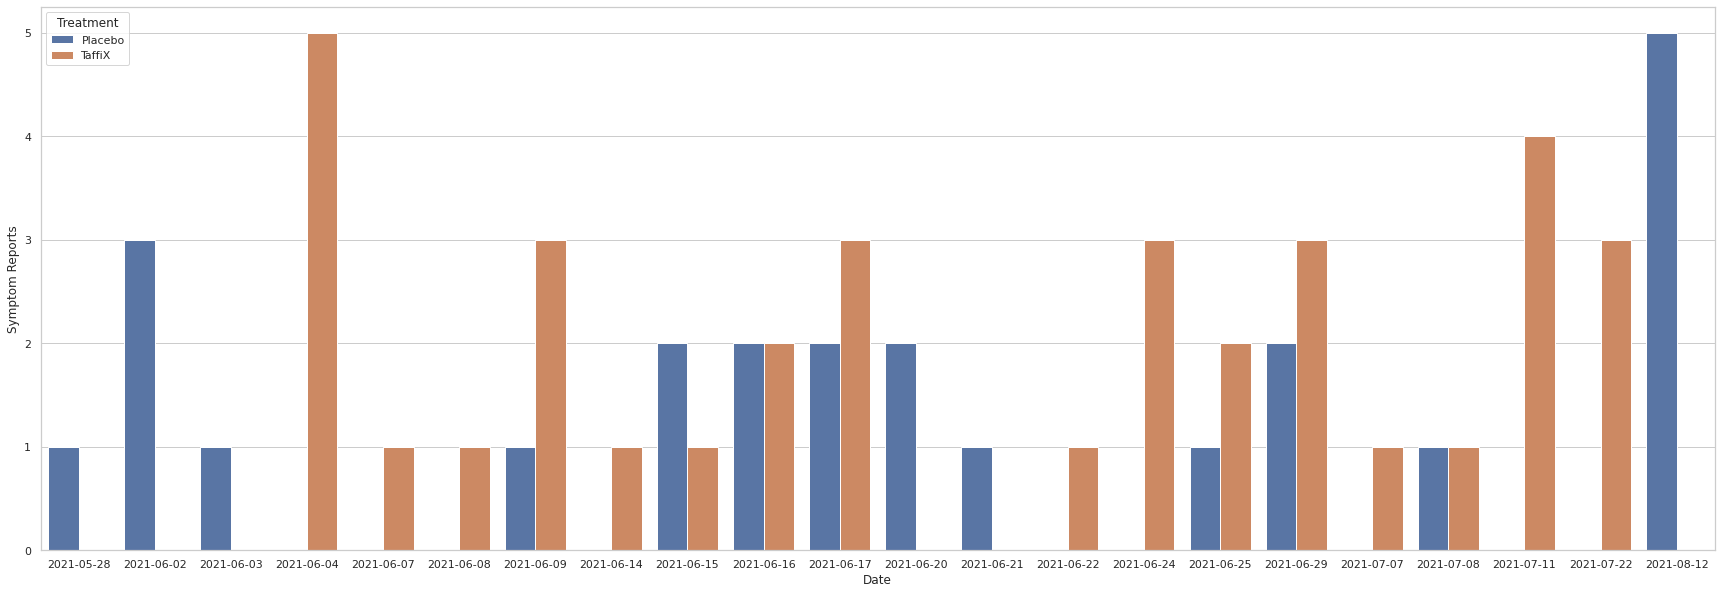

In [467]:
fig = plt.figure(figsize=(30,10))
sns.barplot(x='Date', y='Symptom Reports', hue='Treatment', data=temp_symptom_df.groupby(['Date','Treatment']).count().reset_index())
plt.show()

In [901]:
placebo_symp_rep = temp_symptom_df[temp_symptom_df.Treatment == 'Placebo'].Patient.nunique()
taffix_symp_rep = temp_symptom_df[temp_symptom_df.Treatment == 'TaffiX'].Patient.nunique()

placebo_no_symp_rep = nasus_data.loc[nasus_data['Treatment'] == 'Placebo', 'Patient'].nunique() - placebo_symp_rep
taffix_symp_no_symp_rep = nasus_data.loc[nasus_data['Treatment'] == 'TaffiX', 'Patient'].nunique() - taffix_symp_rep

report_df = pd.DataFrame([{'Yes': placebo_symp_rep, 'No': placebo_no_symp_rep}, {'Yes': taffix_symp_rep, 'No': taffix_symp_no_symp_rep}],
                         index=['Placebo','TaffiX'])
report_df.columns.name = 'Symptom report(s)'
report_df.index.name = 'Treatment'
display(report_df)

# using chi-squared test for contingency tables
chi2, pv, dof, ex = chi2_contingency(report_df, correction=True)

print("Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:")
print("Null hypothesis: Occurrence of any reported symptoms is independant in the type of treatment\n")

print(f'Test statistic: {chi2:.2}')
print(f'P-Value: {pv:.3}')
print('DoF:', dof)
print('Expected frequencies:')
display(ex)

if pv < 0.05:
    print("We reject the null hypothesis with confidence level of 95%")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Symptom report(s)  Yes  No
Treatment                 
Placebo             15  94
TaffiX              21  86

Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:
Null hypothesis: Occurrence of any reported symptoms is independant in the type of treatment

Test statistic: 0.95
P-Value: 0.33
DoF: 1
Expected frequencies:


array([[18.16666667, 90.83333333],
       [17.83333333, 89.16666667]])

Conclusion: We fail to reject the null hypothesis.


In [469]:
breath_diff_df = nasus_data.groupby(['Treatment','Breathing difficulties']).count().Patient
breath_diff_df = pd.DataFrame([{'Yes': breath_diff_df.loc[('Placebo', 1)], 'No': breath_diff_df.loc[('Placebo', 0)]},
                         {'Yes': breath_diff_df.loc[('TaffiX', 1)], 'No': breath_diff_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
breath_diff_df.index.name = 'Treatment'
breath_diff_df.columns.name = 'Breathing difficulties'


cough_df = nasus_data.groupby(['Treatment','Cough']).count().Patient
cough_df = pd.DataFrame([{'Cough': cough_df.loc[('Placebo', 1)], 'No cough': cough_df.loc[('Placebo', 0)]},
                         {'Cough': cough_df.loc[('TaffiX', 1)], 'No cough': cough_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
cough_df.index.name = 'Treatment'


taste_df = nasus_data.groupby(['Treatment','New olfactory and taste disorder(s)']).count().Patient
taste_df = pd.DataFrame([{'Yes': taste_df.loc[('Placebo', 1)], 'No': taste_df.loc[('Placebo', 0)]},
                         {'Yes': taste_df.loc[('TaffiX', 1)], 'No': taste_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
taste_df.index.name = 'Treatment'
taste_df.columns.name = 'New olfactory and taste disorder(s)'


nasal_cong_df = nasus_data.groupby(['Treatment','Occurrence of Runny or stuffy nose']).count().Patient
nasal_cong_df = pd.DataFrame([{'Yes': nasal_cong_df.loc[('Placebo', 1)], 'No': nasal_cong_df.loc[('Placebo', 0)]},
                         {'Yes': nasal_cong_df.loc[('TaffiX', 1)], 'No': nasal_cong_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
nasal_cong_df.index.name = 'Treatment'
nasal_cong_df.columns.name = 'Runny or stuffy nose'


headache_df = nasus_data.groupby(['Treatment','Headache']).count().Patient
headache_df = pd.DataFrame([{'Yes': headache_df.loc[('Placebo', 1)], 'No': headache_df.loc[('Placebo', 0)]},
                         {'Yes': headache_df.loc[('TaffiX', 1)], 'No': headache_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
headache_df.index.name = 'Treatment'
headache_df.columns.name = 'Headache'


myalgia_df = nasus_data.groupby(['Treatment','Myalgia']).count().Patient
myalgia_df = pd.DataFrame([{'Yes': 0, 'No': myalgia_df.loc[('Placebo', 0)]},
                          {'Yes': myalgia_df.loc[('TaffiX', 1)], 'No': myalgia_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
myalgia_df.index.name = 'Treatment'
myalgia_df.columns.name = 'Myalgia'


throat_df = nasus_data.groupby(['Treatment','Sore throat']).count().Patient
throat_df = pd.DataFrame([{'Yes': throat_df.loc[('Placebo', 1)], 'No': throat_df.loc[('Placebo', 0)]},
                          {'Yes': throat_df.loc[('TaffiX', 1)], 'No': throat_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
throat_df.index.name = 'Treatment'
throat_df.columns.name = 'Sore throat'


rigor_df = nasus_data.groupby(['Treatment','Rigors']).count().Patient
rigor_df = pd.DataFrame([{'Yes': 0, 'No': rigor_df.loc[('Placebo', 0)]},
                          {'Yes': rigor_df.loc[('TaffiX', 1)], 'No': rigor_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
rigor_df.index.name = 'Treatment'
rigor_df.columns.name = 'Rigors'


shortness_df = nasus_data.groupby(['Treatment','Shortness of breath']).count().Patient
shortness_df = pd.DataFrame([{'Yes': shortness_df.loc[('Placebo', 1)], 'No': shortness_df.loc[('Placebo', 0)]},
                          {'Yes': shortness_df.loc[('TaffiX', 1)], 'No': shortness_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
shortness_df.index.name = 'Treatment'
shortness_df.columns.name = 'Shortness of breath'


vomit_df = nasus_data.groupby(['Treatment','Vomiting or Diarrhea']).count().Patient
vomit_df = pd.DataFrame([{'Yes': 0, 'No': vomit_df.loc[('Placebo', 0)]},
                          {'Yes': vomit_df.loc[('TaffiX', 1)], 'No': vomit_df.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
vomit_df.index.name = 'Treatment'
vomit_df.columns.name = 'Vomiting or Diarrhea'


use_df = nasus_data.groupby(['Treatment','Page 5: Do you use Taffix in accordance to the instructions provided?']).count().Patient
use_df = pd.DataFrame([{'Always use device according to instructions': use_df.loc[('Placebo', 'Yes')], 'Use device not according to instructions': 0},
                       {'Always use device according to instructions': use_df.loc[('TaffiX', 'Yes')], 'Use device not according to instructions': use_df.loc[('TaffiX', 'No')]}], index=['Placebo','TaffiX'])
use_df.index.name = 'Treatment'


adverse_df = nasus_data.groupby(['Treatment',"Page 11: Has the patient experienced any adverse event/s?"]).count().Patient
adverse_df = pd.DataFrame([{'Yes': adverse_df.loc[('Placebo', 'Yes')], 'No': adverse_df.loc[('Placebo', 'No')]},
                         {'Yes': adverse_df.loc[('TaffiX', 'Yes')], 'No': adverse_df.loc[('TaffiX', 'No')]}], index=['Placebo','TaffiX'])
adverse_df.index.name = 'Treatment'
adverse_df.columns.name = "Experience of adverse event(s)"




adverse_events = nasus_data[nasus_data["Page 11: Has the patient experienced any adverse event/s?"] == "Yes"].copy()

temp = nasus_data[['Treatment','Page 5:  How many working days did you lose due to illness since your last report?']].copy()
agg_df = pd.concat([temp.groupby('Treatment').min(),
                    temp.groupby('Treatment').mean(),
                    temp.groupby('Treatment').max()], axis=1)
agg_df.columns = ['Min','Mean','Max']
agg_df.columns.name = 'Working days lost due to illness'
agg_df = agg_df.T


covid_df = nasus_data.groupby(['Treatment','Page 8:  Patient COVID-19 Status']).count().Patient
covid_df = pd.DataFrame([{'Positive': covid_df.loc[('Placebo', 'Positive')], 'Negative': covid_df.loc[('Placebo', 'Negative')]},
                         {'Positive': covid_df.loc[('TaffiX', 'Positive')], 'Negative': covid_df.loc[('TaffiX', 'Negative')]}], index=['Placebo','TaffiX'])
covid_df.index.name = 'Treatment'
covid_df.columns.name = "COVID-19 Status"

method_df = nasus_data.groupby(['Treatment','Page 8: Test Method']).count().Patient
method_df = pd.DataFrame([{'Rapid Serology test': method_df.loc[('Placebo', 'By Rapid Serology test results')], 'PCR lab test': 0},
                         {'Rapid Serology test': method_df.loc[('TaffiX', 'By Rapid Serology test results')], 'PCR lab test': method_df.loc[('TaffiX', 'By PCR lab test')]}], index=['Placebo','TaffiX'])
method_df.index.name = 'Treatment'
method_df.columns.name = "Positive COVID test method"


hospital_df = nasus_data.fillna({'Page 9:  Hospital lab Serology test results': '0'}).groupby(['Treatment','Page 9:  Hospital lab Serology test results']).count().Patient
hospital_df = pd.DataFrame([{'Performed and positive': hospital_df.loc[('Placebo', 'Positive')], 'Not performed': hospital_df.loc[('Placebo', '0')]},
                         {'Performed and positive': hospital_df.loc[('TaffiX', 'Positive')], 'Not performed': hospital_df.loc[('TaffiX', '0')]}], index=['Placebo','TaffiX'])
hospital_df.index.name = 'Treatment'
hospital_df.columns.name = 'Hospital serology test'


severity_df = nasus_data.groupby(['Treatment',"Page 8: Please complete the patient's severity of illness category"]).count().Patient
severity_df = pd.DataFrame([{'Asymptomatic or pre-symptomatic': severity_df.loc[('Placebo', 'Asymptomatic or Pre-symptomatic Infection: Individuals who test positive for SARS-CoV-2 by virologic testing using a molecular diagnostic (e.g., polymerase chain reaction) or antigen test, but have no symptoms.')], 'Mild Illness': 0},
                         {'Asymptomatic or pre-symptomatic': severity_df.loc[('TaffiX', 'Asymptomatic or Pre-symptomatic Infection: Individuals who test positive for SARS-CoV-2 by virologic testing using a molecular diagnostic (e.g., polymerase chain reaction) or antigen test, but have no symptoms.')], 'Mild Illness': severity_df.loc[('TaffiX', 'Mild Illness: Individuals who have any of the various signs and symptoms of COVID 19 (e.g., fever, cough, sore throat, malaise, headache, muscle pain) without shortness of breath, dyspnea, or abnormal chest imaging.')]}], index=['Placebo','TaffiX'])
severity_df.index.name = 'Treatment'
severity_df.columns.name = 'Illness Severity'


any_symptoms = symptoms.sum(axis=1)
improve_df = nasus_data.loc[any_symptoms[any_symptoms > 0].index].groupby(['Treatment','Page 8:  Patient COVID-19 Status','Page 7:  Does the patient has symptoms or changes in this condition and medication following the use of TaffiX™ or the placebo']).count()[["Patient"]]

display(breath_diff_df)
display(cough_df)
display(taste_df)
display(nasal_cong_df)
display(headache_df)
display(myalgia_df)
display(throat_df)
display(rigor_df)
display(shortness_df)
display(vomit_df)
display(use_df)
display(adverse_df)
display(agg_df)
display(covid_df)
placebo_pos = covid_df.loc['Placebo','Positive']
placebo = covid_df.loc['Placebo'].sum()
taffix_pos = covid_df.loc['TaffiX','Positive']
taffix = covid_df.loc['TaffiX'].sum()
print(f'COVID-19 infection rate among Placebo: {placebo_pos/placebo:.2%}')
print(f'COVID-19 infection rate among TaffiX: {taffix_pos/taffix:.2%}')
display(method_df)
display(hospital_df)
display(severity_df)
display(improve_df)

Breathing difficulties  Yes   No
Treatment                       
Placebo                   3  106
TaffiX                    1  106

Cough  No cough
Treatment                 
Placebo        6       103
TaffiX         4       103

New olfactory and taste disorder(s)  Yes   No
Treatment                                    
Placebo                                1  108
TaffiX                                 2  105

Runny or stuffy nose  Yes   No
Treatment                     
Placebo                 6  103
TaffiX                  8   99

Headache   Yes   No
Treatment          
Placebo      5  104
TaffiX      12   95

Myalgia    Yes   No
Treatment          
Placebo      0  109
TaffiX       2  105

Sore throat  Yes   No
Treatment            
Placebo        1  108
TaffiX         3  104

Rigors     Yes   No
Treatment          
Placebo      0  109
TaffiX       1  106

Shortness of breath  Yes   No
Treatment                    
Placebo                2  107
TaffiX                 1  106

Vomiting or Diarrhea  Yes   No
Treatment                     
Placebo                 0  109
TaffiX                  1  106

Always use device according to instructions  \
Treatment                                                
Placebo                                            109   
TaffiX                                             106   

           Use device not according to instructions  
Treatment                                            
Placebo                                           0  
TaffiX                                            1

Experience of adverse event(s)  Yes  No
Treatment                              
Placebo                          28  81
TaffiX                           29  78

Treatment                          Placebo    TaffiX
Working days lost due to illness                    
Min                               0.000000  0.000000
Mean                              0.055046  0.056075
Max                               5.000000  3.000000

COVID-19 Status  Positive  Negative
Treatment                          
Placebo                10        99
TaffiX                  6       101

COVID-19 infection rate among Placebo: 9.17%
COVID-19 infection rate among TaffiX: 5.61%


Positive COVID test method  Rapid Serology test  PCR lab test
Treatment                                                    
Placebo                                      10             0
TaffiX                                        5             1

Hospital serology test  Performed and positive  Not performed
Treatment                                                    
Placebo                                     10             99
TaffiX                                       5            102

Illness Severity  Asymptomatic or pre-symptomatic  Mild Illness
Treatment                                                      
Placebo                                        10             0
TaffiX                                          4             2

Patient
Treatment Page 8:  Patient COVID-19 Status Page 7:  Does the patient has symptoms or chang...         
Placebo   Negative                         No                                                       21
                                           Yes                                                       2
          Positive                         No                                                        2
                                           Yes                                                       1
TaffiX    Negative                         No                                                       25
                                           Yes                                                       2
          Positive                         No                                                        3

In [68]:
# using chi-squared test for contingency tables
chi2, pv, dof, ex = chi2_contingency(hospital_df, correction=True)

print("Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:")
print("Null hypothesis: Occurrence of an hospital serology test for COVID is independant in the type of treatment\n")

print(f'Test statistic: {chi2:.2}')
print(f'P-Value: {pv:.3}')
print('DoF:', dof)
print('Expected frequencies:')
display(ex)

if pv < 0.05:
    print("We reject the null hypothesis with confidence level of 95%")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:
Null hypothesis: Occurrence of an hospital serology test for COVID is independant in the type of treatment

Test statistic: 1.1
P-Value: 0.301
DoF: 1
Expected frequencies:


array([[  7.56944444, 101.43055556],
       [  7.43055556,  99.56944444]])

Conclusion: We fail to reject the null hypothesis.


In [9]:
# using chi-squared test for contingency tables
chi2, pv, dof, ex = chi2_contingency(covid_df, correction=True)

print("Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:")
print("Null hypothesis: Occurrence of a COVID-19 infection is independant in the type of treatment\n")

print(f'Test statistic: {chi2:.2}')
print(f'P-Value: {chi2:.3}')
print('DoF:', dof)
print('Expected frequencies:')
display(ex)

if pv < 0.05:
    print("We reject the null hypothesis with confidence level of 95%")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:
Null hypothesis: Occurrence of a COVID-19 infection is independant in the type of treatment

Test statistic: 0.55
P-Value: 0.549
DoF: 1
Expected frequencies:


array([[  8.07407407, 100.92592593],
       [  7.92592593,  99.07407407]])

Conclusion: We fail to reject the null hypothesis.


In [780]:
tables = []
for symp in symptoms_df.columns.values[1:]:
    if symp == 'COVID-19 Infection':
        continue
    tbl = nasus_data[nasus_data['Page 8:  Patient COVID-19 Status'] == "Positive"].groupby(['Treatment',symp]).count().Patient
    if sum([ind[1] for ind in tbl.index.values]) >= 0:
        if ('Placebo',0) not in tbl.index.values.tolist():
            tbl.loc[('Placebo',0)] = 0
        if ('Placebo',1) not in tbl.index.values.tolist():
            tbl.loc[('Placebo',1)] = 0
        if ('TaffiX',0) not in tbl.index.values.tolist():
            tbl.loc[('TaffiX',0)] = 0
        if ('TaffiX',1) not in tbl.index.values.tolist():
            tbl.loc[('TaffiX',1)] = 0
        tbl = pd.DataFrame([{'Yes': tbl.loc[('Placebo', 1)], 'No': tbl.loc[('Placebo', 0)]},
                         {'Yes': tbl.loc[('TaffiX', 1)], 'No': tbl.loc[('TaffiX', 0)]}], index=['Placebo','TaffiX'])
        tbl.index.name = 'Treatment'
        tbl.columns.name = symp
        tables.append(tbl)
        

print("Cochran-Mantel-Haenszel Test for Homogeneity:")
print("Null hypothesis: Odds ratios within each symptom strata are equal to 1 (i.e. the proportions are the same).")

cmh = contingency_tables.StratifiedTable(tables=tables)
or_pooled = cmh.oddsratio_pooled
test_null_hyp = cmh.test_null_odds()

print("Pooled odds ratio     ", or_pooled)
print(test_null_hyp,"\n")
if test_null_hyp.pvalue < 0.0001:
    print("Conclusion: We reject the null hypothesis with confidence level of 99.99%.")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Cochran-Mantel-Haenszel Test for Homogeneity:
Null hypothesis: Odds ratios within each symptom strata are equal to 1 (i.e. the proportions are the same).
Pooled odds ratio      0.0
pvalue      8.435842366072421e-05
statistic   15.458015267175572 

Conclusion: We reject the null hypothesis with confidence level of 99.99%.


In [805]:
plt.figure(figsize=(40,10))
sns.barplot(x='Symptom Reports', y='Count', hue='Treatment', data=temp_symptom_df.groupby(['Symptom Reports','Treatment']).count().Patient.reset_index().rename({'Patient':'Count'}, axis=1))
plt.show()

In [875]:
X = nasus_data[['Treatment','Age','Page 2: Gender','Page 2: No. of people who live at your house (including you)','Page 2: Occupation']].copy()
X['Treatment'].replace(to_replace=['Placebo','TaffiX'], value=[0,1], inplace=True)
X['Page 2: Gender'].replace(to_replace=['Male','Female'], value=[0,1], inplace=True)
enc = TargetEncoder(cols=['Page 2: Occupation'])
y = nasus_data['Page 8:  Patient COVID-19 Status']
y.replace(to_replace=['Negative','Positive'], value=[0,1], inplace=True)
X = enc.fit_transform(X, y)

clf1 = LogisticRegression(random_state=0, class_weight='balanced', penalty='none').fit(X, y)
coef_sig_lvl = logit_pvalue(clf1, X)
coefficients = {'Intercept': (round(clf1.intercept_[0], 3), coef_sig_lvl[0])}
coefficients.update({k: (round(v,3), round(s,3)) for k,v,s in zip(X.columns, clf1.coef_.reshape(-1), coef_sig_lvl[1:])})
T = np.arange(0,1.01,0.01)
roc_df = roc(model=clf1, features=X, label=y, xrange=T)

print('Coefficients:\n')
pprint(coefficients)

print('\nClassification Report:\n')
y_pred = clf1.predict(X)
print(classification_report(y, y_pred, labels=[0,1], target_names=['Negative','Positive']))

sns.lineplot(x='FPR', y='TPR', data=roc_df)
plt.title("ROC Curve")
i_x, i_y = roc_df.loc[0,'FPR'], roc_df.loc[0,'TPR']
plt.text(x=i_x, y=i_y, s='⬤({:.2}, {:.2})'.format(i_x, i_y), font={'size':8, 'weight': 'bold'})
abline(slope=1, intercept=0, xrange=T)

plt.show()

Coefficients:

{'Age': (0.003, 0.79),
 'Intercept': (-1.576, 0.02189189729584129),
 'Page 2: Gender': (-0.906, 0.007),
 'Page 2: No. of people who live at your house (including you)': (-0.06, 0.664),
 'Page 2: Occupation': (38.776, 0.0),
 'Treatment': (-1.39, 0.0)}

Classification Report:

              precision    recall  f1-score   support

    Negative       0.98      0.74      0.85       200
    Positive       0.20      0.81      0.33        16

    accuracy                           0.75       216
   macro avg       0.59      0.78      0.59       216
weighted avg       0.92      0.75      0.81       216



[01:34:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

Classification Report:

              precision    recall  f1-score   support

    Negative       0.98      0.99      0.99       200
    Positive       0.92      0.69      0.79        16

    accuracy                           0.97       216
   macro avg       0.95      0.84      0.89       216
weighted avg       0.97      0.97      0.97       216



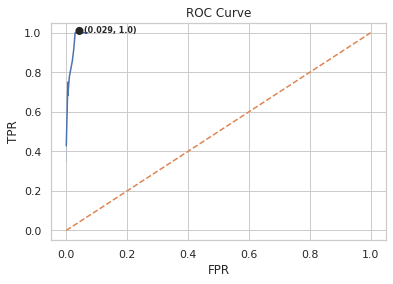

In [817]:
clf2 = xgb.XGBClassifier(random_state=0, booster='gbtree').fit(X, y)
roc_df = roc(model=clf2, features=X, label=y, xrange=T)

print('\nClassification Report:\n')
y_pred = clf2.predict(X)
print(classification_report(y, y_pred, labels=[0,1], target_names=['Negative','Positive']))

sns.lineplot(x='FPR', y='TPR', data=roc_df)
plt.title("ROC Curve")
i_x, i_y = roc_df.loc[0,'FPR'], roc_df.loc[0,'TPR']
plt.text(x=i_x, y=i_y, s='⬤({:.2}, {:.2})'.format(i_x, i_y), font={'size':8, 'weight': 'bold'})
abline(slope=1, intercept=0, xrange=T)

plt.show()

In [818]:
X.columns

Index(['Treatment', 'Age', 'Page 2: Gender',
       'Page 2: No. of people who live at your house (including you)',
       'Page 2: Occupation'],
      dtype='object')

In [821]:
plt.figure(figsize=(10,5))
sns.barplot(x=['Treatment','Age','Gender','Number of Tenants','Occupation'], y=clf2.feature_importances_)
plt.ylabel('Feature Importance (Information Gain)')
plt.show()

In [16]:
# perform Mann-Whitney U-Test (Wilcoxon Rank Sum Test)
# for mean difference in timing of covid-19 between TaffiX and Placebo groups

covid_events = nasus_data[(nasus_data["Page 11: Has the patient experienced any adverse event/s?"] == "Yes") &
                          (nasus_data["Page 8:  Patient COVID-19 Status"] == "Positive")].copy()
covid_events = pd.concat([covid_events[['Treatment','Number of days from visit till occurrence of adverse event(s)']].groupby('Treatment').min(),
                          covid_events.groupby(['Treatment']).mean()['Number of days from visit till occurrence of adverse event(s)'],
                          covid_events[['Treatment','Number of days from visit till occurrence of adverse event(s)']].groupby('Treatment').max()],
                         axis=1)
covid_events.columns = ["Min",
                        "Average",
                        "Max"]
covid_events.columns.name = "Number of days from visit till occurrence of adverse event(s)"
covid_events.index.name = "Treatment"
covid_events = covid_events.T

taffix_pos = nasus_data.loc[(nasus_data['Page 8:  Patient COVID-19 Status']=='Positive') & (nasus_data.Treatment == 'TaffiX'), 'Number of days from visit till occurrence of adverse event(s)'].dropna().values
placebo_pos = nasus_data.loc[(nasus_data['Page 8:  Patient COVID-19 Status']=='Positive') & (nasus_data.Treatment == 'Placebo'), 'Number of days from visit till occurrence of adverse event(s)'].dropna().values


utest = mannwhitneyu(x=taffix_pos, y=placebo_pos, use_continuity=True,
                     alternative='greater', axis=0, method='auto')

display(covid_events)
print("U-test result:")
print(utest)

Treatment                                             Placebo  TaffiX
Number of days from visit till occurrence of ad...                   
Min                                                  6.000000    10.0
Average                                             13.333333    20.0
Max                                                 25.000000    30.0

U-test result:
MannwhitneyuResult(statistic=5.0, pvalue=0.2)


In [487]:
for sym in symptoms_df.columns.values[1:]:
    sym_events = nasus_data[nasus_data[sym] == 1].copy()
    sym_events = pd.concat([sym_events[['Treatment','Days till ' + sym]].groupby('Treatment').min(),
                            sym_events.groupby(['Treatment']).mean()['Days till ' + sym],
                            sym_events[['Treatment','Days till ' + sym]].groupby('Treatment').max()],
                             axis=1)
    sym_events.columns = ["Min",
                          "Average",
                          "Max"]
    sym_events.columns.name = "Number of days from visit till occurrence of {}".format(sym)
    sym_events.index.name = "Treatment"
    sym_events = sym_events.T
    display(sym_events)
    
    taffix_sym = nasus_data.loc[(nasus_data[sym] == 1) & (nasus_data.Treatment == 'TaffiX'), 'Days till ' + sym].dropna().values
    placebo_sym = nasus_data.loc[(nasus_data[sym] == 1) & (nasus_data.Treatment == 'Placebo'), 'Days till ' + sym].dropna().values
    if (len(taffix_sym) > 0) & (len(placebo_sym) > 0):
        utest = mannwhitneyu(x=taffix_sym, y=placebo_sym, use_continuity=True,
                             alternative='greater', axis=0, method='auto')

        print("U-test result:")
        print(utest)

Treatment                                             Placebo  TaffiX
Number of days from visit till occurrence of Cough                   
Min                                                 13.000000   27.00
Average                                             30.166667   34.25
Max                                                 79.000000   46.00

U-test result:
MannwhitneyuResult(statistic=19.0, pvalue=0.08226090874474223)


Treatment                                           TaffiX
Number of days from visit till occurrence of Ri...        
Min                                                   15.0
Average                                               15.0
Max                                                   15.0

Treatment                                           TaffiX
Number of days from visit till occurrence of My...        
Min                                                   10.0
Average                                               12.5
Max                                                   15.0

Treatment                                           Placebo     TaffiX
Number of days from visit till occurrence of He...                    
Min                                                    13.0   7.000000
Average                                                38.2  26.416667
Max                                                    79.0  52.000000

U-test result:
MannwhitneyuResult(statistic=23.0, pvalue=0.7855438408514228)


Treatment                                           TaffiX
Number of days from visit till occurrence of Vo...        
Min                                                   27.0
Average                                               27.0
Max                                                   27.0

Treatment                                           Placebo  TaffiX
Number of days from visit till occurrence of Sh...                 
Min                                                    19.0    18.0
Average                                                49.0    18.0
Max                                                    79.0    18.0

U-test result:
MannwhitneyuResult(statistic=0.0, pvalue=1.0)


Treatment                                             Placebo  TaffiX
Number of days from visit till occurrence of Br...                   
Min                                                  8.000000    34.0
Average                                             33.333333    34.0
Max                                                 79.000000    34.0

U-test result:
MannwhitneyuResult(statistic=2.0, pvalue=0.5)


Treatment                                           Placebo  TaffiX
Number of days from visit till occurrence of Ne...                 
Min                                                     8.0    19.0
Average                                                 8.0    31.0
Max                                                     8.0    43.0

U-test result:
MannwhitneyuResult(statistic=2.0, pvalue=0.3333333333333333)


Treatment                                             Placebo  TaffiX
Number of days from visit till occurrence of Oc...                   
Min                                                 18.000000   18.00
Average                                             36.666667   37.25
Max                                                 79.000000   52.00

U-test result:
MannwhitneyuResult(statistic=32.5, pvalue=0.14924585538348456)


Treatment                                           Placebo  TaffiX
Number of days from visit till occurrence of So...                 
Min                                                    28.0    28.0
Average                                                28.0    42.0
Max                                                    28.0    52.0

U-test result:
MannwhitneyuResult(statistic=2.5, pvalue=0.31867594411696853)


In [902]:
symptoms_data = symptoms_data.merge(randomized_data, on=["Patient"], how="inner")

In [903]:
covid_subjects = nasus_data.loc[nasus_data['Page 8:  Patient COVID-19 Status'] == "Positive", ["Patient"]]
covid_symptomatic = symptoms_data.merge(covid_subjects, on=["Patient"], how="inner")
covid_symptomatic['Symptomatic'] = 'Yes'
covid_asymptomatic = covid_subjects[~covid_subjects.isin(covid_symptomatic.Patient.values)].merge(randomized_data, on=["Patient"], how="inner")
covid_asymptomatic['Symptomatic'] = 'No'
covid_subjects = pd.concat([covid_symptomatic,covid_asymptomatic], axis=0).reset_index(drop=True)
covid_subjects.head()

Patient       Cough      Rigors     Myalgia    Headache  \
0     27.0  2021-06-16  2021-06-04  2021-06-04  2021-06-04   
1    121.0         NaN         NaN         NaN         NaN   
2    215.0         NaN         NaN         NaN  2021-07-22   
3      7.0         NaN         NaN         NaN         NaN   
4     13.0         NaN         NaN         NaN         NaN   

  Vomiting or Diarrhea Shortness of breath Breathing difficulties  \
0           2021-06-16                 NaN                    NaN   
1                  NaN                 NaN                    NaN   
2                  NaN                 NaN                    NaN   
3                  NaN                 NaN                    NaN   
4                  NaN                 NaN                    NaN   

  New olfactory and taste disorder(s) Occurrence of Runny or stuffy nose  \
0                                 NaN                                NaN   
1                                 NaN                         2021-06-25   
2                                 NaN                         2021-07-22   
3                                 NaN                                NaN   
4                                 NaN                                NaN   

  Sore throat Treatment Symptomatic  
0         NaN    TaffiX         Yes  
1         NaN    TaffiX         Yes  
2  2021-07-22    TaffiX         Yes  
3         NaN    TaffiX          No  
4         NaN    TaffiX          No

In [904]:
non_covid_subjects = nasus_data.loc[nasus_data['Page 8:  Patient COVID-19 Status'] == "Negative", ["Patient"]]
non_covid_symptomatic = symptoms_data.merge(non_covid_subjects, on=["Patient"], how="inner")
non_covid_symptomatic['Symptomatic'] = 'Yes'
non_covid_asymptomatic = non_covid_subjects[~non_covid_subjects.isin(non_covid_symptomatic.Patient.values)].merge(randomized_data, on=["Patient"], how="inner")
non_covid_asymptomatic['Symptomatic'] = 'No'
non_covid_subjects = pd.concat([non_covid_symptomatic,non_covid_asymptomatic], axis=0).reset_index(drop=True)
non_covid_subjects.head()

Patient       Cough Rigors Myalgia    Headache Vomiting or Diarrhea  \
0      4.0         NaN    NaN     NaN  2021-06-17                  NaN   
1      5.0         NaN    NaN     NaN         NaN                  NaN   
2     10.0         NaN    NaN     NaN  2021-07-08                  NaN   
3     11.0  2021-06-02    NaN     NaN  2021-06-02                  NaN   
4     22.0         NaN    NaN     NaN         NaN                  NaN   

  Shortness of breath Breathing difficulties  \
0                 NaN                    NaN   
1                 NaN                    NaN   
2                 NaN                    NaN   
3                 NaN             2021-06-02   
4                 NaN                    NaN   

  New olfactory and taste disorder(s) Occurrence of Runny or stuffy nose  \
0                                 NaN                         2021-06-17   
1                          2021-06-08                                NaN   
2                                 NaN                                NaN   
3                                 NaN                                NaN   
4                                 NaN                         2021-07-07   

  Sore throat Treatment Symptomatic  
0         NaN   Placebo         Yes  
1         NaN    TaffiX         Yes  
2         NaN   Placebo         Yes  
3         NaN   Placebo         Yes  
4         NaN    TaffiX         Yes

In [905]:
symptomatic_df = covid_subjects.groupby(['Treatment','Symptomatic']).Patient.count()
symptomatic_df = pd.DataFrame([{'Symptomatic': 0, 'Asymptomatic': symptomatic_df.loc[('Placebo', 'No')]},
                               {'Symptomatic': symptomatic_df.loc[('TaffiX', 'Yes')], 'Asymptomatic': symptomatic_df.loc[('TaffiX', 'No')]}],
                              index=['Placebo','TaffiX'])
symptomatic_df.index.name = 'Treatment'
display(symptomatic_df)

# using chi-squared test for contingency tables
chi2, pv, dof, ex = chi2_contingency(symptomatic_df, correction=True)

print("Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:")
print("Null hypothesis: Occurrence of a symptomatic COVID or asymptomatic COVID is independant in the type of treatment.\n")

print(f'Test statistic: {chi2:.2}')
print(f'P-Value: {pv:.3}')
print('DoF:', dof)
print('Expected frequencies:')
display(ex)

if pv < 0.07:
    print("Conclusion: We reject the null hypothesis with confidence level of 93%.")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Symptomatic  Asymptomatic
Treatment                           
Placebo              0            10
TaffiX               3             3

Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:
Null hypothesis: Occurrence of a symptomatic COVID or asymptomatic COVID is independant in the type of treatment.

Test statistic: 3.3
P-Value: 0.0689
DoF: 1
Expected frequencies:


array([[1.875, 8.125],
       [1.125, 4.875]])

Conclusion: We reject the null hypothesis with confidence level of 93%.


In [908]:
symptomatic_df = non_covid_subjects.groupby(['Treatment','Symptomatic']).Patient.count()
symptomatic_df = pd.DataFrame([{'Symptomatic': 0, 'Asymptomatic': symptomatic_df.loc[('Placebo', 'No')]},
                               {'Symptomatic': symptomatic_df.loc[('TaffiX', 'Yes')], 'Asymptomatic': symptomatic_df.loc[('TaffiX', 'No')]}],
                              index=['Placebo','TaffiX'])
symptomatic_df.index.name = 'Treatment'
display(symptomatic_df)

# using chi-squared test for contingency tables
chi2, pv, dof, ex = chi2_contingency(symptomatic_df, correction=True)

print("Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:")
print("Null hypothesis: Occurrence of a symptomatic COVID or asymptomatic COVID is independant in the type of treatment.\n")

print(f'Test statistic: {chi2:.2}')
print(f'P-Value: {pv:.3}')
print('DoF:', dof)
print('Expected frequencies:')
display(ex)

if pv < 0.00015:
    print("Conclusion: We reject the null hypothesis with confidence level of 99.985%.")
else:
    print("Conclusion: We fail to reject the null hypothesis.")

Symptomatic  Asymptomatic
Treatment                           
Placebo              0            84
TaffiX              18            83

Chi-square test of independence of variables in a contingency table with Yates's correction for continuity:
Null hypothesis: Occurrence of a symptomatic COVID or asymptomatic COVID is independant in the type of treatment.

Test statistic: 1.5e+01
P-Value: 0.000132
DoF: 1
Expected frequencies:


array([[ 8.17297297, 75.82702703],
       [ 9.82702703, 91.17297297]])

Conclusion: We reject the null hypothesis with confidence level of 99.985%.


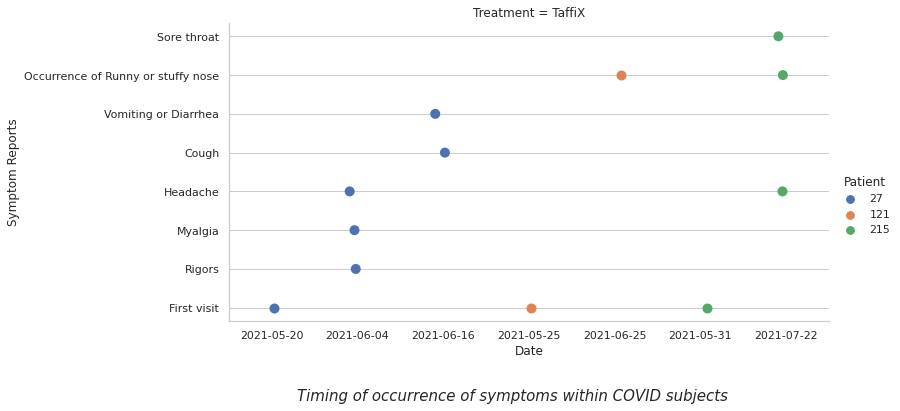

In [751]:
time_series = temp_symptom_df.merge(covid_subjects[['Patient']], on=["Patient"], how="inner")
temp_df = time_series.merge(nasus_data[['Patient','Page 1: Date of visit']], on=['Patient'], how='inner')[['Patient','Treatment','Page 1: Date of visit']]
temp_df.rename({'Page 1: Date of visit': 'Date'}, axis=1, inplace=True)
temp_df['Date'] = temp_df['Date'].apply(lambda x: x.date()).astype(str)
temp_df.drop_duplicates(inplace=True)
time_series = pd.concat([time_series, temp_df], axis=0)
time_series.sort_values(by=['Patient','Date'], inplace=True)
time_series.fillna('First visit', inplace=True)
time_series.reset_index(drop=True, inplace=True)

sns.catplot(x='Date', y='Symptom Reports', hue='Patient', col="Treatment", data=time_series, height=5, aspect=11.7/5, s=10)
plt.text(0.3,-2.4,"Timing of occurrence of symptoms within COVID subjects", fontsize=15, style='oblique')
plt.show()

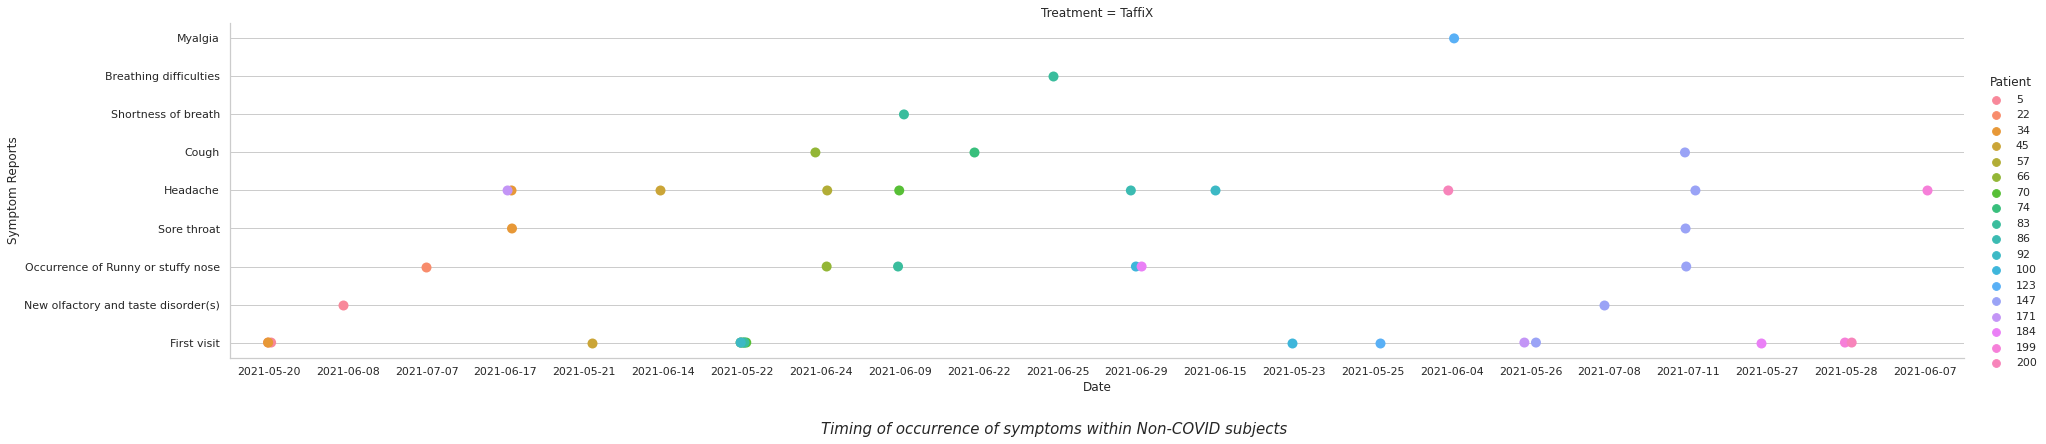

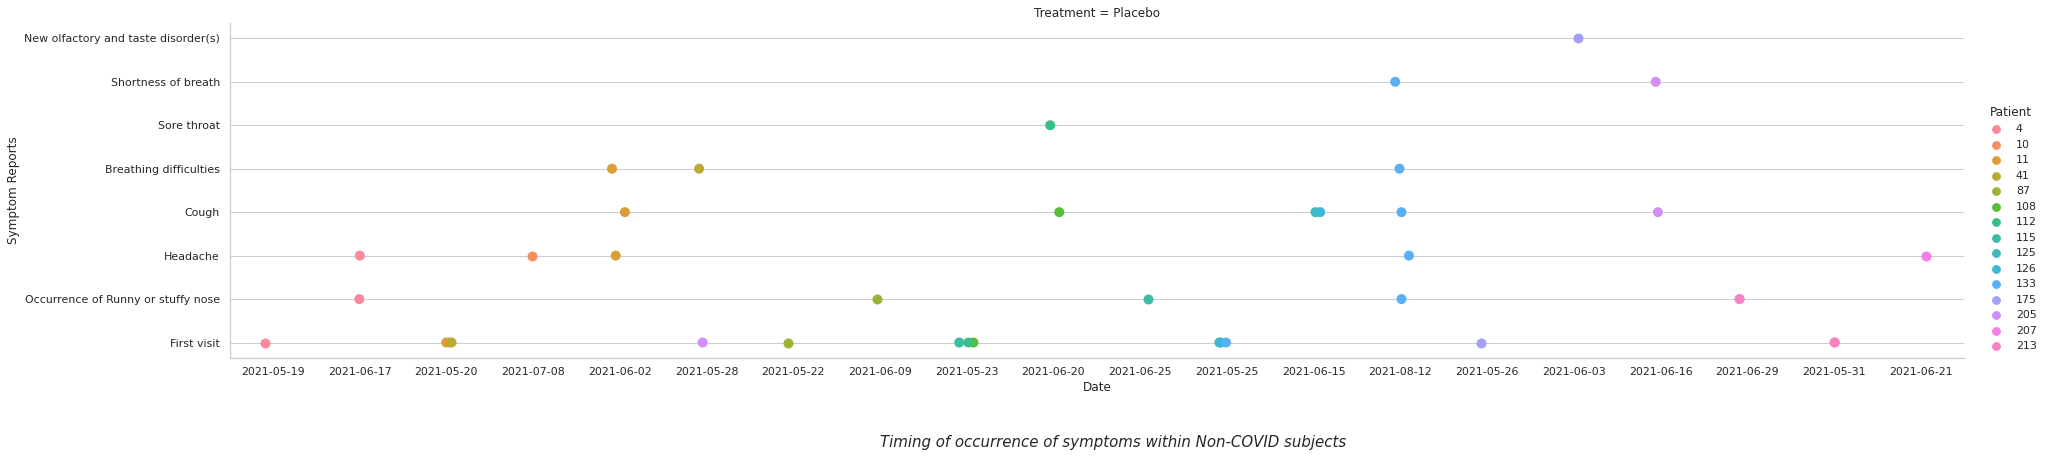

In [763]:
time_series = temp_symptom_df.merge(non_covid_subjects[['Patient']], on=["Patient"], how="inner")
temp_df = time_series.merge(nasus_data[['Patient','Page 1: Date of visit']], on=['Patient'], how='inner')[['Patient','Treatment','Page 1: Date of visit']]
temp_df.rename({'Page 1: Date of visit': 'Date'}, axis=1, inplace=True)
temp_df['Date'] = temp_df['Date'].apply(lambda x: x.date()).astype(str)
temp_df.drop_duplicates(inplace=True)
time_series = pd.concat([time_series, temp_df], axis=0)
time_series.sort_values(by=['Patient','Date'], inplace=True)
time_series.fillna('First visit', inplace=True)
time_series.reset_index(drop=True, inplace=True)

sns.catplot(x='Date', y='Symptom Reports', hue='Patient', col="Treatment", data=time_series[time_series.Treatment=='TaffiX'], height=5.5, aspect=5, s=10)
plt.text(7,-2.4,"Timing of occurrence of symptoms within Non-COVID subjects", fontsize=15, style='oblique')
plt.show()

sns.catplot(x='Date', y='Symptom Reports', hue='Patient', col="Treatment", data=time_series[time_series.Treatment=='Placebo'], height=5.5, aspect=5, s=10)
plt.text(7,-2.4,"Timing of occurrence of symptoms within Non-COVID subjects", fontsize=15, style='oblique')
plt.show()